# Forecasting monthly rainfall in California using Deep Learning Time Series techniques

## Table of Contents <a class="anchor" id="0"></a>
* [Introduction](#1) 
* [Imports](#2)
* [Connecting to ArcGIS](#3)
* [Accessing & Visualizing the datasets](#4) 
* [Timeseries Data Preparation](#5) 
    * [Sequencing Timeseries data](#7)
    * [Datatypes of timeseries variable](#8)
    * [Checking autocorrelation of timeseries variable](#10)   
    * [Train - Test split of timeseries dataset](#6)       
* [Timeseries Model Building](#9)
    * [Data Preprocessing](#11)  
    * [Model Initialization ](#12)
    * [Learning Rate Search ](#13)
    * [Model Training ](#14) 
* [Rainfall Forecast & Validation](#15)   
    * [Forecasting Using the trained Timeseries Model](#26)
    * [Estimate model metrics for validation](#27)
    * [Result Visualization](#28)
* [Conclusion](#23)
* [Summary of methods used](#24)
* [Data resources](#25)

## Introduction <a class="anchor" id="1"></a>

Forest fires of historical proportions are ravaging various parts of California, started by a long and continuous period of drought. To help in dealing with this growing environmental emergency, utilizing prior knowledge of rainfall is critical. In this sample study, the deepelarning timeseries model from ArcGIS learn will be used to predict monthly rainfall for a whole year at a certain location in the Sierra Nevada foothills, around 30 miles north east of Fresno California, using the location's historic rainfall data. Data from January to December of 2019 will be used to validate the quality of the forecast.

Weather forecasting is a popular field for the application of timeseries modelling. There are various approaches used for solving timeseries problems, including classical statistical methods, such as ARIMA group of models, machine learning models, and deep learning models. The current implementation of the ArcGIS learn timeseries model uses state of the art convolutional neural networks backbones especially curated for timeseries datasets. These include InceptionTime, ResCNN, Resnet, and FCN. What makes timeseries modeling unique is that, in the classical methodology of ARIMA, multiple hyperparameters require fine tuning before fitting the model, while with the current deep learning technique, most of the parameters are learned by the model itself from the data.

## Imports <a class="anchor" id="2"></a>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from IPython.display import Image, HTML

from sklearn.model_selection import train_test_split

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata
from arcgis.features import FeatureLayer, FeatureLayerCollection

## Connecting to ArcGIS <a class="anchor" id="3"></a>

In [3]:
gis = GIS("home")

## Accessing & Visualizing datasets  <a class="anchor" id="4"></a> 

The dataset used in this sample study is a univariate timeseries dataset of total monthly rainfall from a fixed location of 1 sqkm area in the state of California, ranging from the January 1980 to December 2019.

The following cell downloads the California rainfall dataset:

In [4]:
url = 'https://services7.arcgis.com/JEwYeAy2cc8qOe3o/arcgis/rest/services/cali_precipitation/FeatureServer/0'
table = FeatureLayer(url)

Next, we preprocess and sort the downloaded dataset by datetime sequence.

In [8]:
cali_rainfall_df1 = table.query().sdf
cali_rainfall_df1 = cali_rainfall_df1.drop("ObjectId", axis=1)
cali_rainfall_df1_sorted = cali_rainfall_df1.sort_values(by='date')
cali_rainfall_df1_sorted.head()

,date,prcp_mm_
1,1980-01-31,224.31
4,1980-02-29,181.84
5,1980-03-31,78.86
8,1980-04-30,34.19
9,1980-05-31,17.57


In [9]:
cali_rainfall_df1_sorted.shape

(480, 2)

In [10]:
cali_rainfall_df1_sorted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 480 entries, 1 to 479
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      480 non-null    datetime64[ns]
 1   prcp_mm_  480 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.2 KB


## Timeseries Data Preparation<a class="anchor" id="5"></a>   
Preparing the data for timeseries modeling consists of the following three steps:

###  Sequencing Timeseries data<a class="anchor" id="7"></a>

The first step consist of establishing the sequence of the timeseries data, which is done by creating a new index that is used by the model for processing the sequential data. 

In [11]:
# The first step consist of reindexing the timeseries data into a sequential series  
cali_rainfall_reindexed = cali_rainfall_df1_sorted.reset_index()
cali_rainfall_reindexed = cali_rainfall_reindexed.drop("index", axis=1)
cali_rainfall_reindexed.head()

,date,prcp_mm_
0,1980-01-31,224.31
1,1980-02-29,181.84
2,1980-03-31,78.86
3,1980-04-30,34.19
4,1980-05-31,17.57


###  Datatypes of timeseries variable<a class="anchor" id="8"></a> 
The next step validates the data types of the variables.

In [12]:
# check the data types of the variables
cali_rainfall_reindexed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      480 non-null    datetime64[ns]
 1   prcp_mm_  480 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.6 KB


Here, the timeseries variable is a float, which should be the expected data type. If the variable is not of a float data type, then it needs to be changed to a float data type, as demonstrated by the commented out line in the next cell.

In [ ]:
#cali_rainfall_reindexed['prcp_mm_'].astype('float64')

###  Checking autocorrelation of timeseries variable<a class="anchor" id="10"></a>
The most important step in this process is to determine if the timeseries sequence is autocorrelated. To ensure that our timeseries data can be modeled well, the strength of correlation of the variable with its past data must be estimated.

In [13]:
from pandas.plotting import autocorrelation_plot

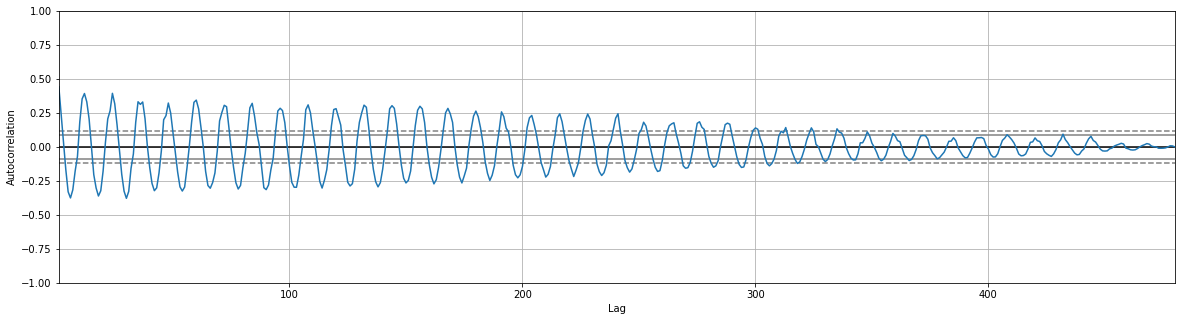

In [14]:
plt.figure(figsize=(20,5))
autocorrelation_plot(cali_rainfall_reindexed["prcp_mm_"])
plt.show()

The plot above shows us that there is significant correlation of the data with its immediate time lagged terms, and that it gradually decreases over time as the lag increases. 

### Train - Test split of timeseries dataset<a class="anchor" id="6"></a>

The dataset above has 480 data samples each representing monthly ranifall of california for 40 years(1980-2019). Out of this 39 years(1980-2018) of data will be used for training the model and the rest 1 year or a total of 12 months of data are held out for validation. Accordingly the dataset is now split into train and test in the following.   

In [15]:
# Splitting timeseries data retaining the original sequence by keeping shuffle=False, and test size of 12 months for validation 
test_size = 12
train, test = train_test_split(cali_rainfall_reindexed, test_size = test_size, shuffle=False)

In [16]:
train 

,date,prcp_mm_
0,1980-01-31,224.31
1,1980-02-29,181.84
2,1980-03-31,78.86
3,1980-04-30,34.19
4,1980-05-31,17.57
...,...,...
463,2018-08-31,0.00
464,2018-09-30,0.00
465,2018-10-31,13.53
466,2018-11-30,113.04


## Model Building <a class="anchor" id="9"></a>

Once the dataset is divided into the training and test dataset, the training data is ready to be used for modeling.

### Data Preprocessing <a class="anchor" id="11"></a>

In this example, the data used is a univariate timeseries of total monthly rainfall in millimeters. This single variable will be used to forecast the 12 months of rainfall for the months subsequent to the last date in the training data, or put simply, a single variable will be used to predict the future values of that same variable. In the case of a multivariate timeseries model, there would be a list of multiple explanatory variables.

Once the variables are identified, the preprocessing of the data is performed by the `prepare_tabulardata` method from the `arcgis.learn` module in the ArcGIS API for Python. This function will take either a non spatial dataframe, a feature layer, or a spatial dataframe containing the dataset as input, and will return a TabularDataObject that can be fed into the model. 

The primary input parameters required for the tool are:

- <span style='background :lightgrey' >input_features</span> : non spatial dataframe, feature layer, or spatial dataframe containing the primary dataset and the explanatory variables, if there are any
- <span style='background :lightgrey' >variable_predict</span> : field name containing the y-variable to be forecasted from the input feature layer/dataframe
- <span style='background :lightgrey' >explanatory_variables</span> : list of the field names as 2-sized tuples containing the explanatory variables as mentioned above. Since there are none in this example, it is not required here 
- <span style='background :lightgrey' >index_field</span> : field name containing the timestamp

At this point, preprocessors could be used for scaling the data using a scaler as follows, depending on the data distribution.

In [17]:
#from sklearn.preprocessing import MinMaxScaler

In [18]:
#preprocessors = [('prcp_mm_', MinMaxScaler())]
#data = prepare_tabulardata(train, variable_predict='prcp_mm_', index_field='date', preprocessors=preprocessors)

In this example, preprocessors are not used, as the data is normalized by default.  

In [19]:
data = prepare_tabulardata(train, variable_predict='prcp_mm_', index_field='date', seed=42)

C:\Users\sup10432\AppData\Local\ESRI\conda\envs\pro_dl_28October\lib\site-packages\arcgis\learn\_utils\tabular_data.py:876: UserWarning: Dataframe is not spatial, Rasters and distance layers will not work
  warnings.warn("Dataframe is not spatial, Rasters and distance layers will not work")


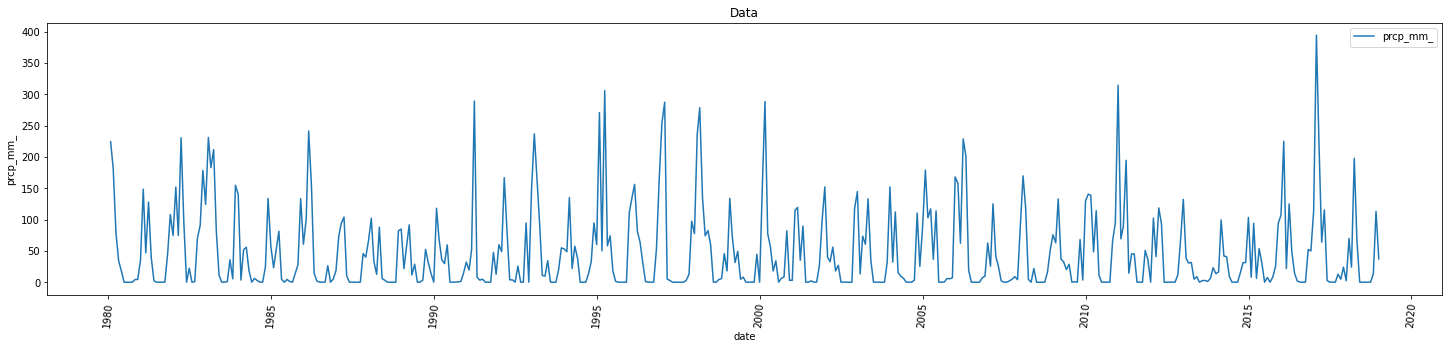

In [20]:
# Visualize the entire timeseries data
data.show_batch(graph=True)

In [21]:
# Here sequence length is used as 12 which also indicates the seasonality of the data
seq_len=12

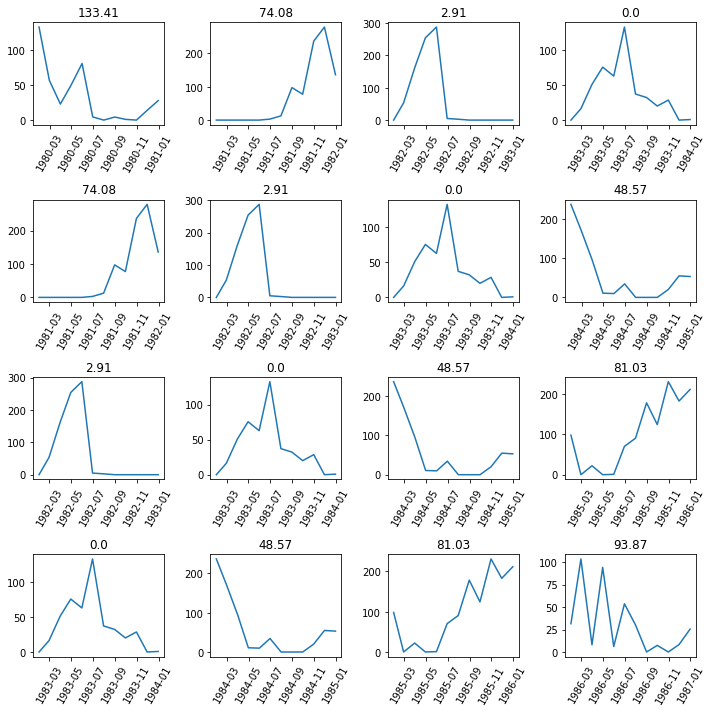

In [22]:
# visualize the timeseries in batches, here the sequence length is mentioned which would be treated as the batch length
data.show_batch(rows=4,seq_len=seq_len)

### Model Initialization <a class="anchor" id="12"></a>

This is the most significant step for fitting a timeseries model. Here, along with the data, the backbone for training the model and the sequence length are passed as parameters. Out of these three, the sequence length has to be selected carefully, as it can make or break the model. The sequence length is usually the cycle of the data, which in this case is 12, as it is monthly data and the pattern repeats after 12 months.

In [23]:
# In model initialization, the data and the backbone is selected from the available set of InceptionTime, ResCNN, Resnet, FCN
ts_model = TimeSeriesModel(data, seq_len=seq_len, model_arch='InceptionTime')

### Learning Rate Search<a class="anchor" id="13"></a>

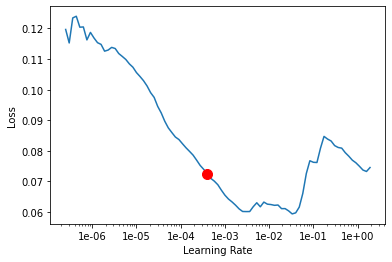

In [24]:
# Finding the learning rate for training the model
l_rate = ts_model.lr_find()

### Model Training <a class="anchor" id="14"></a>

Finally, the model is now ready for training. To train the model, the `model.fit` method is called and is provided the number of epochs for training and the estimated learning rate suggested by `lr_find` in the previous step:

In [25]:
ts_model.fit(100, lr=l_rate)

epoch,train_loss,valid_loss,time
0,0.083008,0.037609,00:00
1,0.061329,0.036617,00:00
2,0.050808,0.036499,00:00
3,0.044877,0.036835,00:00
4,0.039619,0.036479,00:00
5,0.034815,0.034671,00:00
6,0.031023,0.032002,00:00
7,0.028147,0.030694,00:00
8,0.025152,0.026627,00:00
9,0.022742,0.024633,00:00


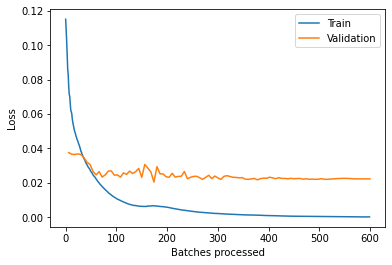

In [26]:
# the train vs valid losses is plotted to check quality of the trained model, and whether the model needs more training 
ts_model.plot_losses()

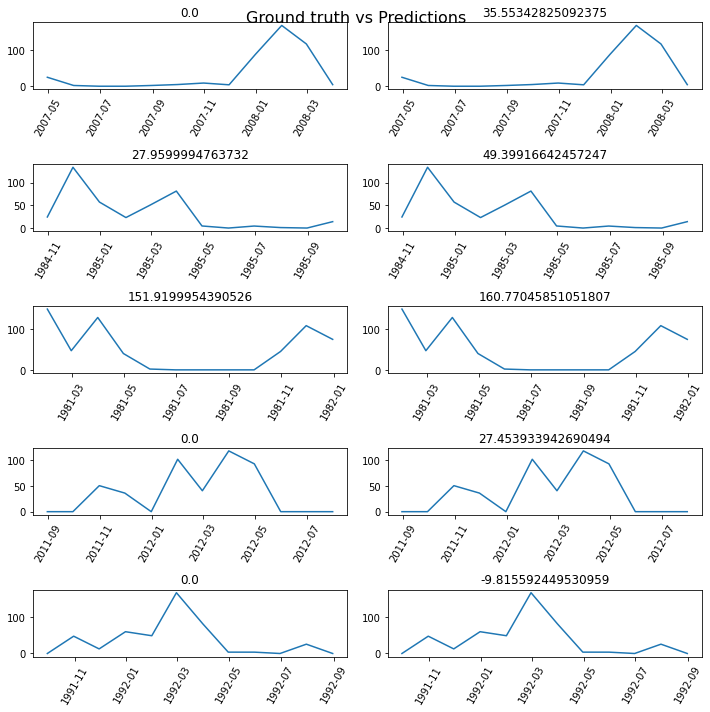

In [27]:
# the predicted values by the trained model is printed for the test set
ts_model.show_results(rows=5)

The figures above display the training and the validation of the prediction attained by the model while training.

## Rainfall Forecast & Validation <a class="anchor" id="15"></a>

### Forecasting Using the trained Timeseries Model <a class="anchor" id="26"></a>
During forecasting, the model will use the same training dataset as input and will use the last sequence length number of terms from that dataset's tail to predict the rainfall for the number of months specified by the user.   

In [29]:
from datetime import datetime  

In [30]:
# checking the training dataset
train

,date,prcp_mm_
0,1980-01-31,224.31
1,1980-02-29,181.84
2,1980-03-31,78.86
3,1980-04-30,34.19
4,1980-05-31,17.57
...,...,...
463,2018-08-31,0.00
464,2018-09-30,0.00
465,2018-10-31,13.53
466,2018-11-30,113.04


Forecasting requires the format of the date column to be in datetime. If the date column is not in the datetime format, it can be changed to datetime by using the `pd.to_datetime()` method. 

In [31]:
# checking if the datatype of the 'date' column is in datetime format
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468 entries, 0 to 467
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      468 non-null    datetime64[ns]
 1   prcp_mm_  468 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.0 KB


In this example, the date column is already in the required datetime format.

In [32]:
train.tail(5)

,date,prcp_mm_
463,2018-08-31,0.00
464,2018-09-30,0.00
465,2018-10-31,13.53
466,2018-11-30,113.04
467,2018-12-31,37.26


Finally the predict function is used to forecast for a period of the 12 months subsequent to the last date in the training dataset. As such, this will be forecasting rainfall for the 12 months of 2019, starting from January of 2019.

In [33]:
# Here the forecast is returned as a dataframe, since it is non spatial data, mentioned in the 'prediction_type'     
sdf_forecasted = ts_model.predict(train, prediction_type='dataframe', number_of_predictions=test_size)

C:\Users\sup10432\AppData\Local\ESRI\conda\envs\pro_dl_28October\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [34]:
# final forecasted result returned by the model
sdf_forecasted

,date,prcp_mm_,prcp_mm__results
0,1980-01-31,224.31,224.310000
1,1980-02-29,181.84,181.840000
2,1980-03-31,78.86,78.860000
3,1980-04-30,34.19,34.190000
4,1980-05-31,17.57,17.570000
...,...,...,...
475,2019-08-20,NaN,-5.099367
476,2019-09-18,NaN,10.751540
477,2019-10-17,NaN,25.207242
478,2019-11-15,NaN,83.685172


In [35]:
# Formating the result into actual vs the predicted columns
sdf_forecasted = sdf_forecasted.tail(test_size)
sdf_forecasted = sdf_forecasted[['date','prcp_mm__results']]
sdf_forecasted['actual'] = test[test.columns[-1]].values
sdf_forecasted = sdf_forecasted.set_index(sdf_forecasted.columns[0])
sdf_forecasted.head()

,prcp_mm__results,actual
date,,
2019-01-29,129.882450,149.69
2019-02-27,144.863222,222.38
2019-03-28,143.764554,102.48
2019-04-26,48.772594,25.12
2019-05-25,61.366233,102.49


### Estimate model metrics for validation <a class="anchor" id="27"></a>
The accuracy of the forecasted values is measured by comparing the forecasted values against the actual values of the 12 months.

In [36]:
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

In [37]:
r2_test = r2_score(sdf_forecasted['actual'],sdf_forecasted['prcp_mm__results'])
print('R-Square: ', round(r2_test, 2))

R-Square:  0.8


A considerably high r-squared value indicates a high similarity between the forecasted and the actual sales values.

In [38]:
mse_RF_train = metrics.mean_squared_error(sdf_forecasted['actual'], sdf_forecasted['prcp_mm__results'])
print('RMSE: ', round(np.sqrt(mse_RF_train), 4))

mean_absolute_error_RF_train = metrics.mean_absolute_error(sdf_forecasted['actual'], sdf_forecasted['prcp_mm__results'])
print('MAE: ', round(mean_absolute_error_RF_train, 4))

RMSE:  32.2893
MAE:  25.5549


The error terms of RMSE and MAE in the forecasting are 32.28mm and 25.55mm respectively, which are quite low.

## Result Visualization<a class="anchor" id="28"></a>

Finally, the actual and forecasted values are plotted to visualize their distribution over the 12 months period, with the blue lines indicating forecasted values and orange line showing the actual values.

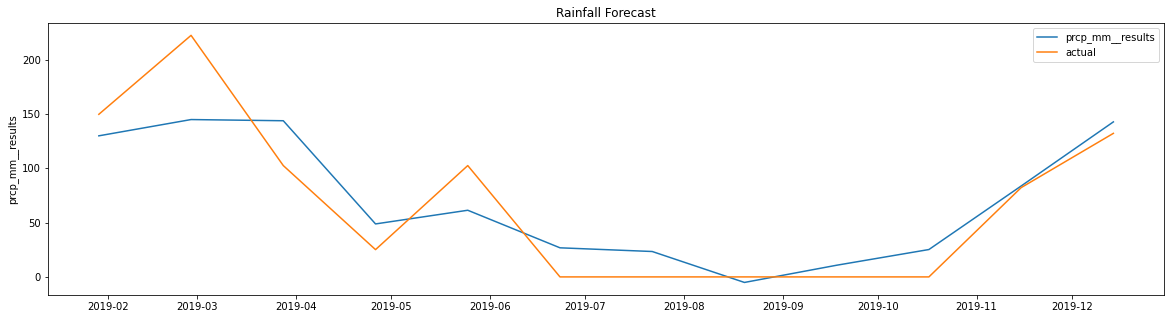

In [39]:
plt.figure(figsize=(20,5))
plt.plot(sdf_forecasted)
plt.ylabel('prcp_mm__results')
plt.legend(sdf_forecasted.columns.values,loc='upper right')
plt.title( 'Rainfall Forecast')
plt.show()

## Conclusion<a class="anchor" id="23"></a>

The newly implemented deeplearning timeseries model from the arcgis.learn library was used to forecast monthly rainfall for a location of 1 sqkm in California, for the period of January to December 2019, which it was able to model with a high accuracy. The notebook elaborates on the methodology of applying the model for forecasting time series data. The process includes first preparing a timeseries dataset using the prepare_tabulardata() method, followed by modeling and fitting the dataset. Usually, timeseries modelling requires fine tuning several hyperparameters for properly fitting the data, most of which has been internalized in this current implementation, leaving the user responsible for configuring only a few significant parameters, like the sequence length.   

### Summary of methods used <a class="anchor" id="24"></a>

| Method | Description | Examples |
| -| - |-|
| prepare_tabulardata| prepare data including imputation, normalization and train-test split  |prepare data ready for fitting a  Timeseries Model 
| model.lr_find()| find an optimal learning rate  | finalize a good learning rate for training the Timeseries model
| TimeSeriesModel() | Model Initialization by selecting the Timeseries Deeplearning algorithm to be used for fitting  | Selected Timsereis algorithm from Fastai timeseries regression can be used
| model.fit() | train a model with epochs & learning rate as input  | training the Timeseries model with sutiable input 
| model.score() | find the model metric of R-squared of the trained model  | returns R-squared value after training the Timeseries Model 
| model.predict() | predict on a test set | forecast values using the trained models on test input 

### Data resources <a class="anchor" id="25"></a>

| Dataset | Source | Link |
| -| - |-|
|California Daily weather data|MODIS - Daily Surface Weather Data on a 1-km Grid for North America, Version 3|https://daac.ornl.gov/DAYMET/guides/Daymet_V3_CFMosaics.html|